In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from __future__ import print_function
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


In [2]:
train_data_dir = '/Users/mac/Desktop/AI/Facial Expression Recognition/archive/train'
validate_data_dir = '/Users/mac/Desktop/AI/Facial Expression Recognition/archive/test'

In [3]:
# Define the selected categories
selected_classes = ['happy', 'sad','surprise', 'neutral']
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Get indices of the selected categories
selected_indices = [class_labels.index(label) for label in selected_classes]

In [4]:
def load_images(data_dir, max_per_class=100):
    data = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    # Filter out classes that are not in selected_classes
    class_names = [class_name for class_name in class_names if class_name in selected_classes]
    
    for label_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        count = 0
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))
            data.append(img)
            labels.append(selected_classes.index(class_name))  # Label as per selected_classes
            count += 1
            if count >= max_per_class:
                break
    return shuffle(np.array(data), np.array(labels), random_state=42)


In [5]:
# Load and shuffle train and validation
X_train_raw, y_train = load_images(train_data_dir)
X_val_raw, y_val = load_images(validate_data_dir)

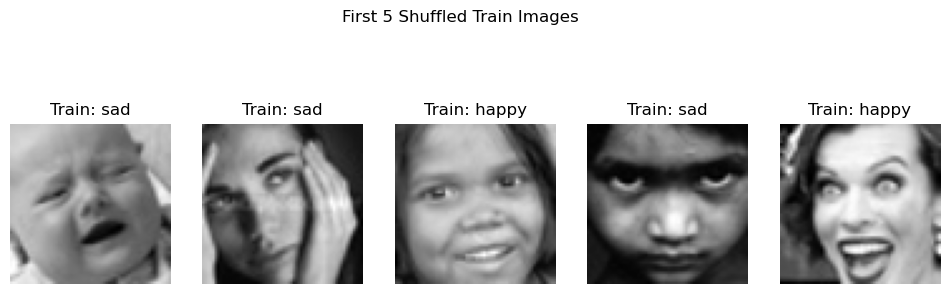

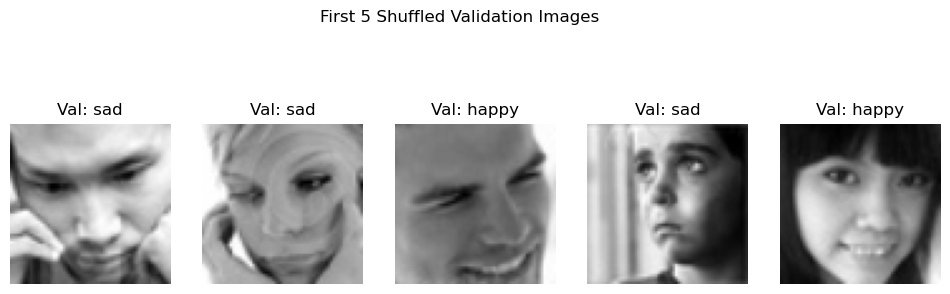

In [6]:
# Show first 5 from train
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_raw[i], cmap='gray')
    plt.title(f"Train: {selected_classes[y_train[i]]}")
    plt.axis('off')
plt.suptitle("First 5 Shuffled Train Images")
plt.show()

# Show first 5 from validation
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val_raw[i], cmap='gray')
    plt.title(f"Val: {selected_classes[y_val[i]]}")
    plt.axis('off')
plt.suptitle("First 5 Shuffled Validation Images")
plt.show()

In [7]:
def preprocess_images(images):
    processed = []
    for img in images:
        hist_eq = cv2.equalizeHist(img)
        denoised_img = cv2.fastNlMeansDenoising(hist_eq, h=15, templateWindowSize=7, searchWindowSize=21)

        # Apply sharpening and blend
        sharpening_kernel = np.array([[0, -1, 0],
                                      [-1, 5, -1],
                                      [0, -1, 0]])
        sharpened = cv2.filter2D(denoised_img, -1, sharpening_kernel)

        alpha = 0.3  # increase alpha for more sharpening
        blended = cv2.addWeighted(denoised_img, 1 - alpha, sharpened, alpha, 0)

        norm_img = blended.astype('float32') / 255.0
        processed.append(norm_img)

    return np.expand_dims(np.array(processed), axis=-1)


In [8]:
# Preprocess both train and validation
X_train = preprocess_images(X_train_raw)
X_val = preprocess_images(X_val_raw)

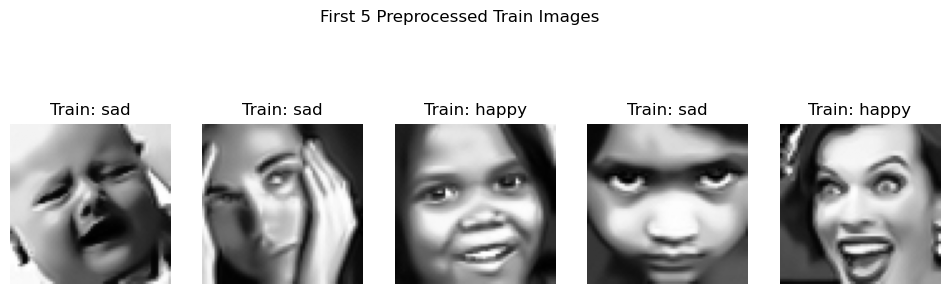

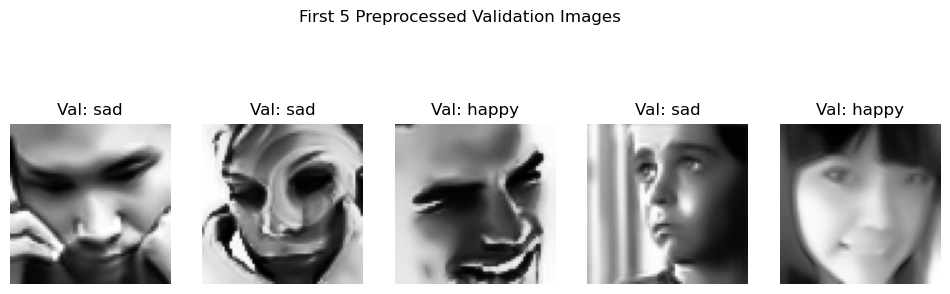

In [9]:
# Show first 5 preprocessed train images
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Train: {selected_classes[y_val[i]]}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Train Images")
plt.show()

# Show first 5 preprocessed validation images
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title(f"Val: {selected_classes[y_val[i]]}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Validation Images")
plt.show()


In [10]:
X_train.shape, y_train.shape, X_val_raw.shape, y_val.shape

((400, 64, 64, 1), (400,), (400, 64, 64), (400,))

In [11]:
from sklearn.preprocessing import LabelEncoder
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [20]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import prewitt, scharr, laplace, gabor
from skimage.restoration import denoise_tv_chambolle
import cv2
import numpy as np

def extract_features_from_image(img):
    # Ensure the image is in 2D grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Normalize image for OpenCV if needed
    if gray.max() <= 1:
        gray = (gray * 255).astype(np.uint8)

    # 1. Sobel Edge Detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edge = np.sqrt(sobelx**2 + sobely**2)

    # 2. Canny Edge Detection
    try:
        canny_edges = cv2.Canny(gray, 100, 200)
    except Exception as e:
        print(f"Error applying Canny edge detection: {e}")
        canny_edges = np.zeros_like(gray)

    # 3. HOG
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # 4. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')

    # 5. Gaussian Blur
    blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)

    # 6. Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # 7. Scharr
    scharr_edge = scharr(gray)

    # 8. Prewitt
    prewitt_edge = prewitt(gray)

    # 9. Median Filter
    median_filtered = cv2.medianBlur(gray, 5)

    # 10. Gabor Filter
    gabor_response, _ = gabor(gray, frequency=0.6)

    # Return all 2D feature images
    return (
        sobel_edge,
        canny_edges,
        hog_image,
        lbp,
        blurred_img,
        laplacian,
        scharr_edge,
        prewitt_edge,
        median_filtered,
        gabor_response
    )

# Dataset feature extraction (same as before)
def extract_features_for_dataset(X_data):
    all_features = []
    for img in X_data:
        img = img.reshape(64, 64)
        features = extract_features_from_image(img)
        all_features.append(features)
    return np.array(all_features)


In [21]:
# Assuming X_train and X_test are your training and test datasets
X_train_feat = extract_features_for_dataset(X_train)
X_val_feat = extract_features_for_dataset(X_val)

# Print shapes of the extracted feature sets
print(f"Shape of extracted features for X_train: {X_train_feat.shape}")
print(f"Shape of extracted features for X_test: {X_val_feat.shape}")

Shape of extracted features for X_train: (400, 10, 64, 64)
Shape of extracted features for X_test: (400, 10, 64, 64)


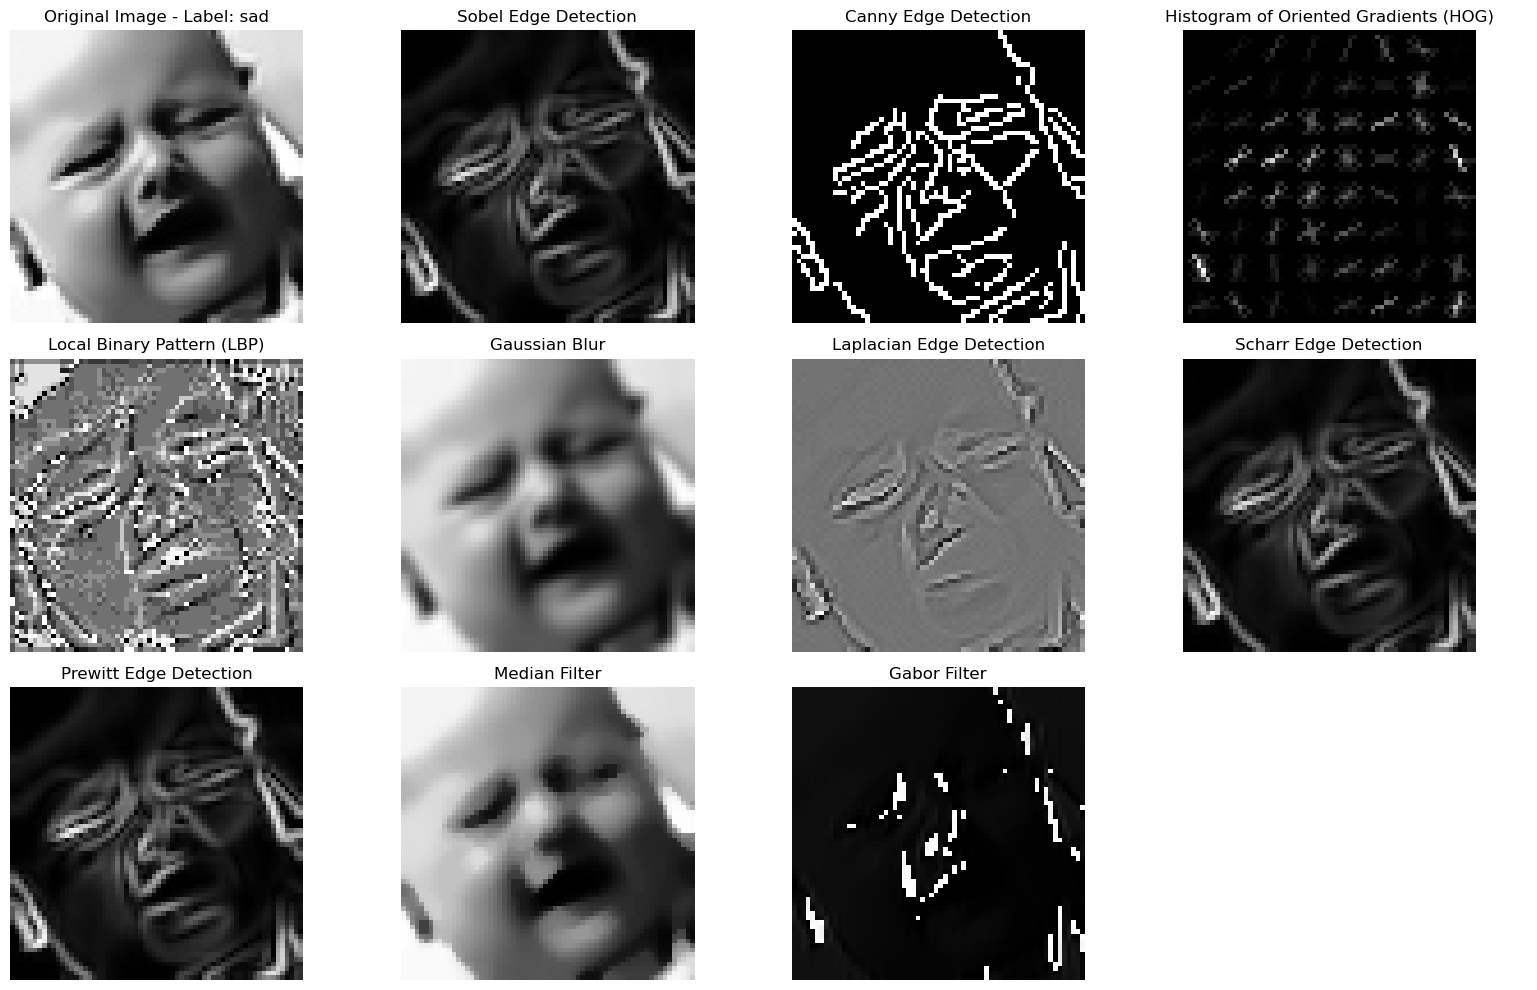

In [23]:
# First image and label
first_image = X_train[0].reshape(64, 64)
first_image_label = selected_classes[y_train[0]]

# Extract features (this function now returns 10 feature images)
features = extract_features_from_image(first_image)

# Titles for each feature
titles = [
    f"Original Image - Label: {first_image_label}",
    "Sobel Edge Detection",
    "Canny Edge Detection",
    "Histogram of Oriented Gradients (HOG)",
    "Local Binary Pattern (LBP)",
    "Gaussian Blur",
    "Laplacian Edge Detection",
    "Scharr Edge Detection",
    "Prewitt Edge Detection",
    "Median Filter",
    "Gabor Filter"
]

# Prepare figure with enough subplots (3 rows x 4 cols)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

# Flatten axes to loop easily
axes = axes.flatten()

# Plot original image first
axes[0].imshow(first_image, cmap='gray')
axes[0].set_title(titles[0])
axes[0].axis('off')

# Plot all feature maps
for i, feature_img in enumerate(features):
    axes[i + 1].imshow(feature_img, cmap='gray')
    axes[i + 1].set_title(titles[i + 1])
    axes[i + 1].axis('off')

# Hide any remaining unused subplots (if less than 12)
for j in range(len(features) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [24]:
# Flatten the extracted feature set
X_train_feat_flattened = X_train_feat.reshape(X_train_feat.shape[0], -1)  # Flatten each sample
X_val_feat_flattened = X_val_feat.reshape(X_val_feat.shape[0], -1)  # Flatten each sample

# Print the new shape to verify
print(f"Shape of flattened features for X_train: {X_train_feat_flattened.shape}")
print(f"Shape of flattened features for X_test: {X_val_feat_flattened.shape}")


Shape of flattened features for X_train: (400, 40960)
Shape of flattened features for X_test: (400, 40960)


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_feat_flattened, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_val_feat_flattened)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")

Accuracy on test data: 42.50%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.53      0.52       100
           1       0.30      0.35      0.33       100
           2       0.56      0.48      0.52       100
           3       0.35      0.34      0.35       100

    accuracy                           0.42       400
   macro avg       0.43      0.42      0.43       400
weighted avg       0.43      0.42      0.43       400

Accuracy: 0.4250


In [26]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert data into DMatrix, which is the format XGBoost prefers
dtrain = xgb.DMatrix(X_train_feat_flattened, label=y_train)
dval = xgb.DMatrix(X_val_feat_flattened, label=y_val)

# Set hyperparameters for XGBoost (you can experiment with these later)
params = {
    'objective': 'multi:softmax',  # multi-class classification
    'num_class': len(set(y_train)),  # number of unique classes in y_train
    'max_depth': 6,  # depth of the tree
    'eta': 0.1,  # learning rate
    'silent': 1,  # suppress warnings
    'eval_metric': 'merror'  # classification error rate
}

# Train the model
num_round = 100  # number of boosting rounds (trees)
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the validation data
y_pred_xgb = bst.predict(dval)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy on test data using XGBoost: {accuracy_xgb * 100:.2f}%")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on test data using XGBoost: 45.25%


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import cv2

# ⚠️ Confirm image shape
X_train = X_train.reshape(-1, 64, 64, 1)
X_val = X_val.reshape(-1, 64, 64, 1)

# ✅ Label sanity check (important!)
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))

# ✅ Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# ✅ Improved CNN (fewer filters, better generalization)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(le.classes_), activation='softmax')
])

# ✅ Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

# ✅ Train
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) ,
    epochs=50,
    validation_data=(X_val, y_val),
    # callbacks=[reduce_lr, early_stop]
)

# ✅ Evaluate
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Unique labels in y_train: [0 1 2 3]
Unique labels in y_val: [0 1 2 3]


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  7/400 ━━━━━━━━━━━━━━━━━━━━ 1:17 197ms/step - accuracy: 0.3034 - loss: 1.5433

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2804 - loss: 1.5029 - val_accuracy: 0.2500 - val_loss: 1.3862
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2475 - loss: 1.4617 - val_accuracy: 0.2500 - val_loss: 1.3867
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2846 - loss: 1.4421 - val_accuracy: 0.2500 - val_loss: 1.3871
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3049 - loss: 1.4208 - val_accuracy: 0.2500 - val_loss: 1.3877
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2898 - loss: 1.3944 - val_accuracy: 0.2500 - val_loss: 1.3881
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3126 - loss: 1.3831 - val_accuracy: 0.2500 - val_loss: 1.3882
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2701 - loss: 1.4241 - val_accuracy: 0.2500 - val_loss: 1.3882
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2723 - loss: 1.3958 - val_accuracy: 0.2500 - val_

In [28]:
model.save('/Users/mac/Desktop/AI/Facial Expression Recognition/model.keras')